In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pyccl as ccl
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit

plt.rcParams['figure.dpi'] = 85
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['legend.title_fontsize'] = 16
plt.rcParams['axes.linewidth'] = 2.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.major.size'] = 4.32
plt.rcParams['ytick.minor.size'] = 2.46
plt.rcParams['xtick.major.width'] = 1.6
plt.rcParams['xtick.minor.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.6
plt.rcParams['ytick.minor.width'] = 1.2

# Figure 6: Plot $b_1$, $b_2$, and $b_3$ for measured vs analytic bias
### Define some global variables

In [2]:
home = '/oak/stanford/orgs/kipac/users/mahlet/bias/'

In [3]:
z_array = [0, 0.5, 1, 1.5]

cmap_red = plt.get_cmap('Reds')(np.linspace(0.333, 0.999, 4))
cmap_blue = plt.get_cmap('Blues')(np.linspace(0.333, 0.999, 4))
cmap_total = plt.get_cmap('Purples')(np.linspace(0.333, 0.999, 4))
color_red = cmap_red[1] 
color_blue = cmap_blue[1]
color_total = cmap_total[1] 

In [4]:
bins_offset = 0.1
bins = np.logspace(10, 15+bins_offset, 50)

In [5]:
h = 0.6774
Delta = 200
delta_c = 1.686

In [6]:
cosmo_default = ccl.Cosmology(Omega_b=0.0486, Omega_c=0.2589, h=h, n_s=0.9667, sigma8=0.8159)
hmf = ccl.halos.MassFuncTinker10()

In [7]:
cmap_AB = plt.get_cmap('Greys')(np.linspace(0.333, 0.999, 4))
cmap_ABR = plt.get_cmap('Reds')(np.linspace(0.333, 0.999, 4))

### Define some functions

In [8]:
def error(hodtype, z, color, density, AB = ''):

    invmats = np.load(home + 'data/'+AB+'mpiinvmat_%shod_z%s_Ndown1_nbias5_%s_%s.npy'%(hodtype, z, color, density))
    nbar = np.load(home + 'data/'+AB+'mpinbar_%shod_z%s_Ndown1_nbias5_%s_%s.npy'%(hodtype, z,color, density))
    covvals = invmats.real[k1_idx]/nbar/Lbox**3  # divided by 2pi/dk is the same as times dx

    return np.sqrt(np.diag(covvals)) #/2

In [9]:
def b1(b1_L):
    return 1+b1_L # eq B.4 in lazeyras et al
    
def b2(b1):
    return 0.412 - 2.143*b1 + 0.929*b1**2 + 0.008*b1**3 # eq 5.2 in lazeyras et al
    
def b2_L(b2, b1_L):
    return (b2 - 8/21*b1_L)/2 # eq B.5 in lazeyras et al
    
def bs2_L(bs2, b1_L): # the so-called Lagrangian local-in-matter-density (LLIMD) prediction
    return bs2 + 2/7*b1_L

def b3(b1):
    return -1.028 + 7.646*b1 - 6.227*b1**2 + 0.912*b1**3 # eq 5.3 in lazeyras et al

def b3_L(b1_L, b2_L):
    return (b3(b1(b1_L))+796/1323*b1_L+13/7*2*b2_L)/6 # eq B.6 in lazeyras et al

In [10]:
def scale_factor(z):
    return 1/(1+z)
    
def recenter(bins):
    return 0.5*(bins[1:]+bins[:-1])

In [11]:
def nu(M, delta_c = delta_c, a = 1, cosmo = cosmo_default):
    
    sigma = cosmo.sigmaM(M/cosmo['h'], a = a)
   
    return delta_c/sigma

In [12]:
def n_g_theory(bins, n_total, a = 1, cosmo = cosmo_default, hmf = hmf):

    nm = hmf(cosmo, recenter(bins)/cosmo['h'], a)/cosmo['h']**3
    n_g = nm/(recenter(bins)*np.log(10))*n_total
    n_g[np.isnan(n_g)]=0
    
    return n_g, nm

def bias(bins, n_m, a = 1, cosmo = cosmo_default, mod = False):

    n_g, nm = n_g_theory(bins, n_m, a = a, cosmo = cosmo)
    n_g = np.trapz(n_g, recenter(bins))
    dm = np.diff(bins) 
    dn_dm = nm/(recenter(bins)*np.log(10))

    b1_E_tinker = b1_E_func(nu(recenter(bins), a = a, cosmo = cosmo), mod = mod)
    b1_L_tinker = b1_L_func(b1_E_tinker)
    
    b2_E_lazeyras = b2(b1_E_tinker)
    b2_L_lazeyras = b2_L(b2_E_lazeyras, b1_L_tinker) 
    
    bs2_L_abidi = bs2_L_func(bins)
    bs2_lazeyras = bES_s2_L(b1_E_tinker)
    bs2_L_lazeyras = bs2_L(bs2_lazeyras, b1_L_tinker)

    b3_E_tinker = b3(b1_E_tinker)
    b3_L_lazeyras = b3_L(b1_L_tinker, b2_L_lazeyras)

    n_m[~np.isfinite(n_m)]=0 
    integrand = dn_dm*n_m
    integrand[np.isnan(integrand)]=0
    bias_params = [b1_L_tinker, b2_L_lazeyras, bs2_L_abidi, bs2_L_lazeyras, b3_L_lazeyras]
    
    return [bias_function(n_g, integrand, i, bins) for i in bias_params], n_g

In [13]:
def b1_E_func(nu, Delta = Delta, delta_c = delta_c, mod = False):

    delta_c = 1.686
    
    if mod == False:
        y = np.log10(Delta)
        A =  1.0+0.24*y*np.exp(-(4/y)**4)
        a = 0.44*y-0.88
        B = 0.183
        b =  1.5
        C = 0.019+0.107*y+0.19*np.exp(-(4/y)**4)
        c = 2.4
        
    else:
        A =  1.0
        a = 0.0906
        B = -4.5002
        b =  2.1419
        C = 4.9148
        c = 2.1419
        
    return 1-A*nu**a/(nu**a+delta_c**a)+B*nu**b+C*nu**c # Jose et al

def b1_L_func(b1_E):
    return b1_E-1 

def bs2_L_func(bins): # eq 5.1 in Abidi et al
    return -0.5*(recenter(bins)/(4e14))**0.8

def bES_s2_L(b1):
    return 0.524 - 0.547*b1 + 0.046*b1**2 # eq. 4.2 in lazeyras et al
    
def bias_function(n_g, integrand, b, bins):
    return 1/n_g*np.trapz(integrand*b, recenter(bins))

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_27173/3934980188.py:4: SyntaxWarning: invalid escape sequence '\m'
  ylabel = ['$b_1^{\mathrm{T10}}$', '$b_2^{\mathrm{L16}}$', '$b_{3}^{\mathrm{L16}}$']
/tmp/ipykernel_27173/3934980188.py:4: SyntaxWarning: invalid escape sequence '\m'
  ylabel = ['$b_1^{\mathrm{T10}}$', '$b_2^{\mathrm{L16}}$', '$b_{3}^{\mathrm{L16}}$']
/tmp/ipykernel_27173/3934980188.py:4: SyntaxWarning: invalid escape sequence '\m'
  ylabel = ['$b_1^{\mathrm{T10}}$', '$b_2^{\mathrm{L16}}$', '$b_{3}^{\mathrm{L16}}$']


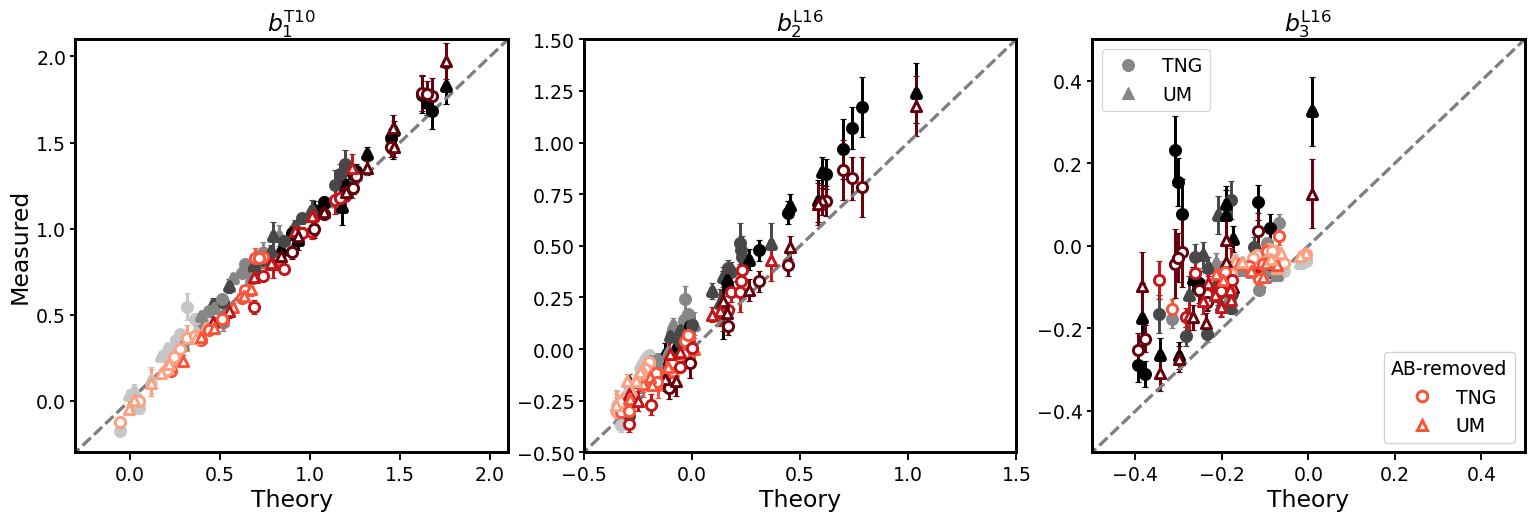

In [14]:
colors_patch = ['red', 'blue', 'total']
bounds = [[-0.3, 2.1], [-0.5, 1.5], [-0.5, 0.5]] 
xlabel = ['$b_1$', '$b_2$', '$b_{s^2}$']
ylabel = ['$b_1^{\mathrm{T10}}$', '$b_2^{\mathrm{L16}}$', '$b_{3}^{\mathrm{L16}}$']
Lbox = 205
cmap_patch = [cmap_red, cmap_blue, cmap_total]
hodtypes = ['TNG', 'UM']
k1_idx = np.load(home + 'data/k1_idx.npy')
cosmo = cosmo_default
colors_cmap_patch = [color_red, color_blue, color_total] 

fig = plt.figure(figsize = (22,4.5)) 
grid = gridspec.GridSpec(1, 3)
grid.update(wspace = 0.175, hspace = 0.075, bottom = -0.2) 

for prefix, legend_title, cmap in zip(['', 'AB_'], ['', 'AB-removed'], [cmap_AB, cmap_ABR]):

    k = 0
    ax1 = plt.subplot(grid[k, 0])
    ax2 = plt.subplot(grid[k, 1])
    ax3 = plt.subplot(grid[k, 2])
    axlist = [ax1, ax2, ax3] #https://www.geeksforgeeks.org/matplotlib-gridspec-gridspec-class-in-python/
    
    for j, ax, l in zip(range(len(bounds)), axlist, [0, 1, 4]):
    
        for color in colors_patch: 
            for hodtype, marker in zip(hodtypes, ['o','^']):
                for density_plot in ['low', 'high', 'medium']: 
        
                    for redshift, i in zip(z_array, range(len(z_array))):
    
                        # load bias measurement
                        biasval = np.load(home + 'data/'+prefix+'mpibiasval_'+hodtype+'hod_z'+str(redshift)+'_Ndown1_nbias5_'+color+'_'+
                                          density_plot+'.npy')   
    
                        # compute total HOD
                        n_total = np.load(home+'data/AB_n_total_z'+str(redshift)+'_'+color+'_'+hodtype+'_'+density_plot+'.npy')
    
                        # load error bars
                        err = error(hodtype, redshift, color, density_plot)

                        if prefix == '':
                            ax.scatter(bias(bins, n_total, a = scale_factor(redshift), cosmo = cosmo)[0][l], biasval[:,l][k1_idx],
                                       color = cmap[i], marker = marker, linewidth = 5, zorder = 3) 
                        else:
                            ax.scatter(bias(bins, n_total, a = scale_factor(redshift), cosmo = cosmo)[0][l], biasval[:,l][k1_idx],
                                       facecolors = 'white', edgecolors = cmap[i], marker = marker, linewidth = 2.5, zorder = 3, s = 75) #label = legend_label
                        ax.errorbar(bias(bins, n_total, a = scale_factor(redshift), cosmo = cosmo)[0][l], biasval[:,l][k1_idx], yerr = err[l],
                                    color = cmap[i], fmt = 'none', elinewidth = 2.5, capsize = 2.5) 
        
        ax.plot(np.linspace(-1,8), np.linspace(-1,8), linestyle = '--', linewidth = 2.5, color = 'grey')
        
        if j==0:
            ax.set_ylabel("Measured")
        ax.set_xlabel("Theory")
        ax.set_title(ylabel[j])
        ax.set_xlim(bounds[j])
        ax.set_ylim(bounds[j])

    if prefix == '':
        custom_lines = [Line2D([0], [0], color = cmap[1], markersize = 10, marker = 'o', linestyle = 'None'), 
                        Line2D([0], [0], color = cmap[1], markersize = 10, marker = '^', linestyle = 'None')]
        second_legend = plt.legend(custom_lines, hodtypes, loc = 'upper left', title = legend_title)
    else:
        custom_lines = [Line2D([0], [0], color = cmap[1], markersize = 9, marker = 'o', linestyle = 'None', markerfacecolor = 'white', markeredgewidth = 2.5), 
                        Line2D([0], [0], color = cmap[1], markersize = 9, marker = '^', linestyle = 'None', markerfacecolor = 'white', markeredgewidth = 2.5)]
        second_legend = plt.legend(custom_lines, hodtypes, loc = 'lower right', title = legend_title)
    ax.add_artist(second_legend)

plt.savefig(home + 'figures/Figure6.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

# Figure 7: Plot the stochasticity
### Define a function

In [15]:
def quadfunc(k, A, B):
    return A*(k/0.8)**2 + B

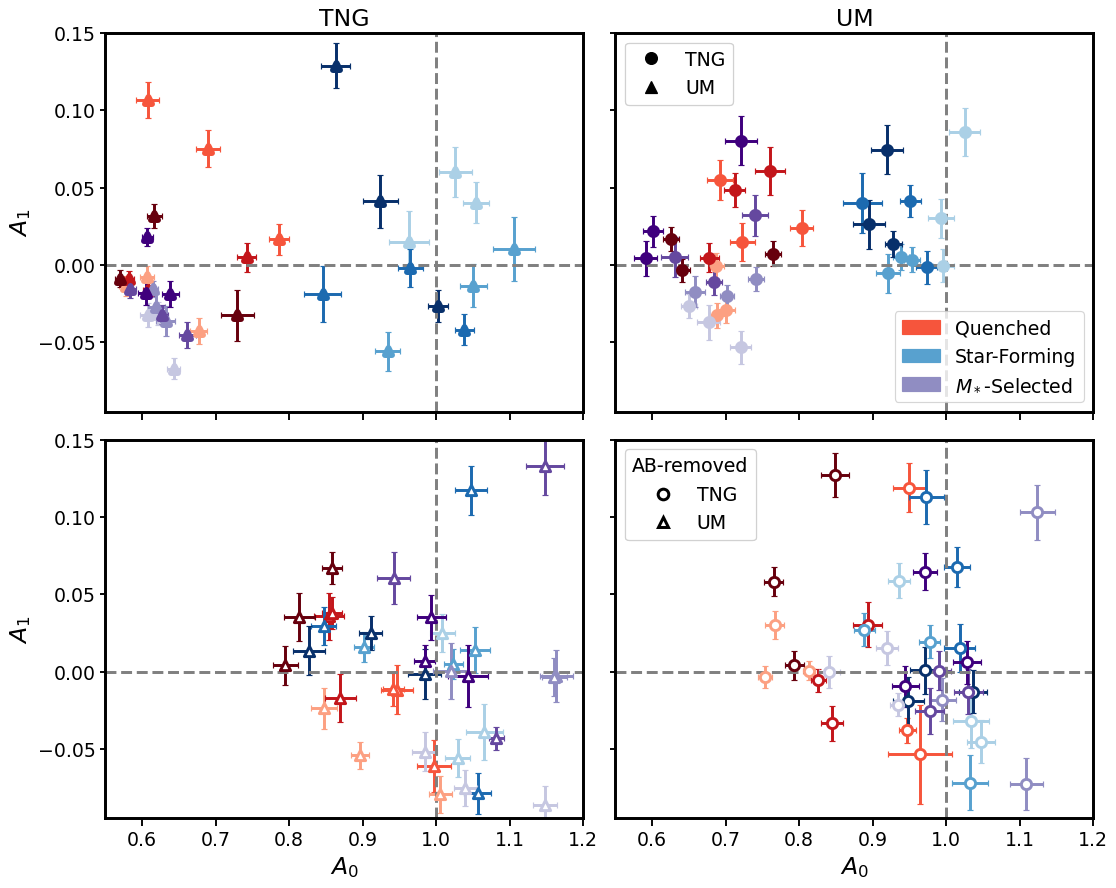

In [16]:
plt.figure(figsize = (15,12))
grid = gridspec.GridSpec(2, 2)
grid.update(wspace = 0.067, hspace = 0.075)
labels = ['Quenched', 'Star-Forming', '$M_*$-Selected']

ploti = 0
for hodtype, marker in zip(hodtypes, ['^','o']):
    grid0 = plt.subplot(grid[ploti])
    grid1 = plt.subplot(grid[ploti+2])
    for color, plot_color in zip(['red', 'blue', 'total'], cmap_patch):        
        for density in ['low', 'high', 'medium']:
            for j in range(len(z_array)):
                
                nbar = np.load(home+'data/mpinbar_%shod_z%s_Ndown1_nbias5_%s_%s.npy'%(hodtype,z_array[j],color,density))
                perr = np.load(home+'data/mpiksumperr_%shod_z%s_kmax0.20_Ndown1_nbias%d_%s_%s.npy'%(hodtype,z_array[j], 5,color,density))
                kbins = np.load(home+'data/mpikvals_%shod_z%s_Ndown1_nbias5_%s_%s.npy'%(hodtype,z_array[j],color,density))
                kidx = (kbins < 1.0)&(kbins > 0.08)
                
                snfit = curve_fit(quadfunc, kbins[kidx], (perr*nbar)[kidx])
                grid0.scatter(snfit[0][1], snfit[0][0], color = plot_color[j], marker = marker, linewidth = 5, zorder = 3)
                grid0.errorbar(snfit[0][1], snfit[0][0], yerr=np.sqrt(snfit[1][1][1]), xerr=np.sqrt(snfit[1][0][0]), color = plot_color[j], fmt = 'none', elinewidth = 2.5, capsize = 2.5)              
                
                nbar = np.load(home+'data/AB_mpinbar_%shod_z%s_Ndown1_nbias5_%s_%s.npy'%(hodtype,z_array[j],color,density))
                perr = np.load(home+'data/AB_mpiksumperr_%shod_z%s_kmax0.20_Ndown1_nbias%d_%s_%s.npy'%(hodtype,z_array[j], 5,color,density))
                kbins = np.load(home+'data/AB_mpikvals_%shod_z%s_Ndown1_nbias5_%s_%s.npy'%(hodtype,z_array[j],color,density))
                kidx = (kbins < 1.0)&(kbins > 0.08)
                
                snfit = curve_fit(quadfunc, kbins[kidx], (perr*nbar)[kidx])
                grid1.scatter(snfit[0][1], snfit[0][0], facecolors = 'white', edgecolors = plot_color[j], marker = marker, linewidth = 2.5, zorder = 3, s = 75)
                grid1.errorbar(snfit[0][1], snfit[0][0], yerr=np.sqrt(snfit[1][1][1]), xerr=np.sqrt(snfit[1][0][0]), color = plot_color[j], fmt = 'none', elinewidth = 2.5, capsize = 2.5)   
            
    grid0.set_title(hodtype)
    grid0.set_xticklabels([])
    grid1.set_xlabel(r'$A_0$')

    for gridi in [grid0,grid1]:
        gridi.set_xlim(0.55, 1.2)
        gridi.set_ylim(-0.095, 0.15)
        gridi.axhline(0, linestyle = '--', color = 'grey', linewidth = 2.5)
        gridi.axvline(1, linestyle = '--', color = 'grey', linewidth = 2.5)     

    if hodtype == 'UM':
        grid0.set_yticklabels([])
        grid1.set_yticklabels([])
        patch = [mpatches.Patch(color=colors_cmap_patch[i], label=labels[i]) for i in range(len(labels))]
        first_legend = grid0.legend(handles=patch, loc = 'lower right')
        grid0.add_artist(first_legend)
        custom_lines = [Line2D([0], [0], color = 'black', markersize = 10, marker = 'o', linestyle = 'None'), 
                        Line2D([0], [0], color = 'black', markersize = 10, marker = '^', linestyle = 'None')]
        second_legend = grid0.legend(custom_lines, hodtypes, loc = 'upper left')
        grid0.add_artist(second_legend)
        
        custom_lines = [Line2D([0], [0], markeredgecolor = 'black', markersize = 9, marker = 'o', linestyle = 'None', markerfacecolor = 'white', 
                               markeredgewidth = 2.5), 
                        Line2D([0], [0], markeredgecolor = 'black', markersize = 9, marker = '^', linestyle = 'None', markerfacecolor = 'white', 
                               markeredgewidth = 2.5)]
        second_legend = grid1.legend(custom_lines, hodtypes, loc = 'upper left', title = 'AB-removed')
        grid1.add_artist(second_legend)
    else:
        grid0.set_ylabel(r'$A_1$')
        grid1.set_ylabel(r'$A_1$')
    ploti+=1

plt.savefig(home+'figures/Figure7.pdf', dpi = 300, bbox_inches = 'tight')